In [1]:
import os
import sys
sys.path.append('../')
from catalogue_demo.constants import OPENAI_API_KEY
import utils
import pickle

import openai
# import openai.ChatCompletion as ChatCompletion 
from langchain.chains import ConversationalRetrievalChain, RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.embeddings import OpenAIEmbeddings
from langchain.indexes import VectorstoreIndexCreator
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
from langchain.llms import OpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
#summary imports
from langchain.chains.summarize import load_summarize_chain
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import UnstructuredFileLoader


from langchain.output_parsers import ResponseSchema
from langchain.output_parsers import StructuredOutputParser

#visualizations imports
import networkx as nx
import matplotlib.pyplot as plt

os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

In [33]:
# from langchain.output_parsers import ResponseSchema
# from langchain.output_parsers import StructuredOutputParser

# class_schema = ResponseSchema(
#     name="problem class",
#     description="how to discribe the aspect of the problem? for example: supportive, mechanical, IT, etc.",
# )
# sub_class_schema = ResponseSchema(
#     name="sub_class", description="a more specific title to the problem."
# )
# description_schema = ResponseSchema(
#     name="problem",
#     description="a description of the problem.",
# )

# response_schemas = [class_schema, sub_class_schema, description_schema]
# parser = StructuredOutputParser.from_response_schemas(response_schemas)
# format_instructions = parser.get_format_instructions()
# format_instructions


# template = """Classify the below problem to general class and more detailed class in a hierarchical way.

#                 just return the jason, do not add ANYTHING, NO INTERPRETATIONS!
                
#                 the problem is: {problem}
                
#                 {format_instructions}
#                 """
# prompt = ChatPromptTemplate.from_template(template=template)

# format_instructions = parser.get_format_instructions()

# messages = prompt.format_messages(
#     problem=problems_list[0],
#     format_instructions=format_instructions,
# )

# chat = ChatOpenAI(temperature=0.0)
# response = chat(messages)
# # print('response:', response)

# output_dict = parser.parse(response.content)
# output_dict


In [ ]:
def long_summary(text, chank_size = 2000):
    text_splitter = RecursiveCharacterTextSplitter(
        # Set a really small chunk size, just to show.
        chunk_size = chank_size,
        chunk_overlap = 0
    )
    small_chanks = text_splitter.split_documents(text)
    # llm = OpenAI()#model="gpt-3.5-turbo")
    llm = ChatOpenAI(temperature = 0, model='gpt-3.5-turbo')
    chain = load_summarize_chain(llm, chain_type="map_reduce", verbose=True)
    summary = chain.run(small_chanks)

    return summary

gl_loader = UnstructuredFileLoader("../shared_ideas/data.txt")
gl_doc = gl_loader.load()
print(gl_doc[:100])
print(long_summary(gl_doc))

[Document(page_content='Gun laws in Israel are comprehensive despite soldiers being allowed to carry their service weapons on or off duty. Civilians must obtain a firearms license to lawfully acquire, possess, sell or transfer firearms and ammunition. In 2018, Israel significantly loosened firearms restrictions, allowing all citizens who had undergone combat training and qualified in Advanced Infantry Training (\'Rifleman "07"\') to apply for a private handgun license. [256]\n\nPrior to 2018, only a small group of people had been eligible for firearms licenses: certain retired military personnel, police officers or prison guards; residents of settlements (in the West Bank) or those who often work in such towns; and licensed hunters and animal-control officers. Age requirements vary: 21 for those who completed military service or civil service equivalent, 27 otherwise, and 45 for non-citizens. Firearm license applicants must have been a resident of Israel for at least three consecutive 

In [ ]:
def summary(new_text, old_summary = ""):
    template = ""
    if old_summary == "":
        template = """summarize the text below:{old_summary}
                    {input}"""
    else:
        template = """use the old summary = {old_summary} 
                    and create a summary that contains the old summary and the new text: {input}
                    """
    
    instractions = """
                    rules for the summary:
                    1. start with a 2-4 words that describe the topic, example: topic: gun control in Israel
                    2. don't add information that could be wrong and not in the text.
                    3. use clear and simple language.
                """
    template = template + instractions
    prompt = PromptTemplate(input_variables={"input", "old_summary"}, template=template)
    llm = ChatOpenAI(temperature = 0.5, model='gpt-3.5-turbo')
    chain = LLMChain(llm=llm, prompt=prompt)
    result = chain.run(input = new_text, old_summary = old_summary)

    return result

text = ""
with open("data.txt", "r") as f:
    text = f.read()
summary = summary(text)
print(summary)  


Topic: Gun laws in Israel

Summary: Gun laws in Israel are comprehensive, requiring civilians to obtain a firearms license to legally acquire, possess, sell, or transfer firearms and ammunition. In 2018, restrictions were loosened, allowing qualified citizens with combat training to apply for a private handgun license. Prior to this, only specific groups, such as retired military personnel and licensed hunters, were eligible. Applicants must pass background checks, establish a genuine reason for firearm possession, and undergo weapons training. License holders must renew their licenses every three years and demonstrate safe storage. Organizations can issue carry-licenses to their members, and shooting club members can possess additional firearms. Licensed individuals are allowed to carry handguns loaded in public. There are a significant number of licensed firearms in Israel, along with some illegal gun ownership.


: 

In [ ]:
def logic_statment(text):
    template = """you are a logic expert, meaning break the text below into simpel logic statements.
                for example: we need to reduce wight so the car will be faster.
                the logic statment will be: lighter car -> move faster.
                after that you need to say rater the statment is reasonable or not.
                the text = {input}"""
    prompt = PromptTemplate(input_variables={"input"}, template=template)
    llm = ChatOpenAI(temperature = 0.5, model='gpt-3.5-turbo')
    chain = LLMChain(llm=llm, prompt=prompt)
    result = chain.run(input = text)

    return result

print(logic_statment("if kobi won't play with us we will sure lose the game"))

Statement: If Kobi doesn't play with us, we will definitely lose the game.

Logic statement: Not playing with Kobi -> Losing the game.

Reasonability: The statement is reasonable. The absence of Kobi's participation implies a negative outcome for the team, resulting in losing the game.


## Workflow

In [71]:
%reload_ext autoreload
%autoreload 2

import importlib
from utils import *
import utils

# importlib.reload(utils)


problems = [
    "1. Insufficient storage compartments for organizing different items efficiently.",
    "2. Lack of durability in the material used, leading to frequent wear and tear.",
    "3. Inadequate support and padding in the shoulder straps causing discomfort during extended use.",
    "4. Limited waterproofing capabilities, making the backpack vulnerable to damage in rainy conditions."
]
{'main_class': 'Storage', 'sub_class': 'Insufficient compartments', 'description': 'Insufficient storage compartments for organizing different items efficiently.'}
{'main_class': 'Durability', 'sub_class': 'Material quality', 'description': 'Lack of durability in the material used, leading to frequent wear and tear.'}
{'main_class': 'Comfort', 'sub_class': 'Shoulder strap support', 'description': 'Inadequate support and padding in the shoulder straps causing discomfort during extended use.'}
{'main_class': 'Waterproofing', 'sub_class': 'Limited capabilities', 'description': 'Limited waterproof

(<networkx.classes.graph.Graph at 0x1b13537e130>,
 {'backpack': (365.64, 162.0),
  'Storage': (166.64, 90.0),
  'Insufficient compartments': (104.64, 18.0),
  'Durability': (312.64, 90.0),
  'Material quality': (294.64, 18.0),
  'Comfort': (453.64, 90.0),
  'Shoulder strap support': (471.64, 18.0),
  'Waterproofing': (626.64, 90.0),
  'Limited capabilities': (661.64, 18.0)})

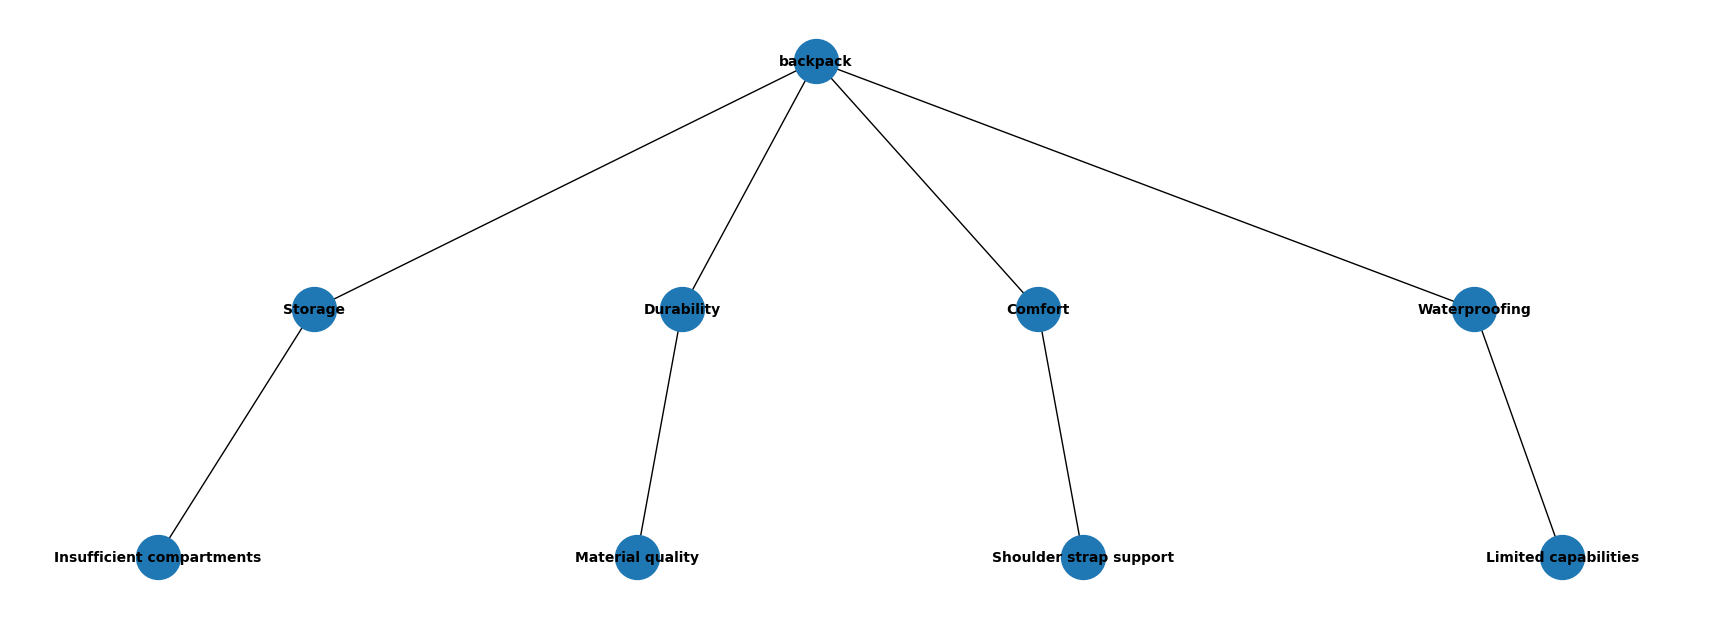

In [6]:
top2 = Topic("backpack")
top2.generate_problems(4)
top2.plot_hierarchy_problems()

{'main_class': 'Storage', 'sub_class': 'Insufficient Compartments', 'description': 'Insufficient storage compartments for organizing different items efficiently.'}
{'main_class': 'Durability', 'sub_class': 'Material Wear and Tear', 'description': 'Lack of durability in the material used, leading to frequent wear and tear.'}
{'main_class': 'Comfort', 'sub_class': 'Shoulder Strap Support', 'description': 'Inadequate support and padding in the shoulder straps causing discomfort during extended use.'}
{'main_class': 'Waterproofing', 'sub_class': 'Limited Capabilities', 'description': 'Limited waterproofing capabilities, making the backpack vulnerable to damage in rainy conditions.'}
{'main_class': 'Comfort', 'sub_class': 'Belt Discomfort', 'description': 'My backpack belt is hurting my sides when the backpack is heavy.'}
{'main_class': 'Durability', 'sub_class': 'Zipper Breakage', 'description': 'The zippers are breaking after a year of use.'}


(<networkx.classes.graph.Graph at 0x1b13510b5b0>,
 {'backpack': (597.59, 162.0),
  'Storage': (256.59, 90.0),
  'Insufficient Compartments': (106.59, 18.0),
  'Durability': (507.59, 90.0),
  'Material Wear and Tear': (325.59, 18.0),
  'Comfort': (688.59, 90.0),
  'Shoulder Strap Support': (688.59, 18.0),
  'Waterproofing': (923.59, 90.0),
  'Limited Capabilities': (1037.6, 18.0),
  'Belt Discomfort': (868.59, 18.0),
  'Zipper Breakage': (507.59, 18.0)})

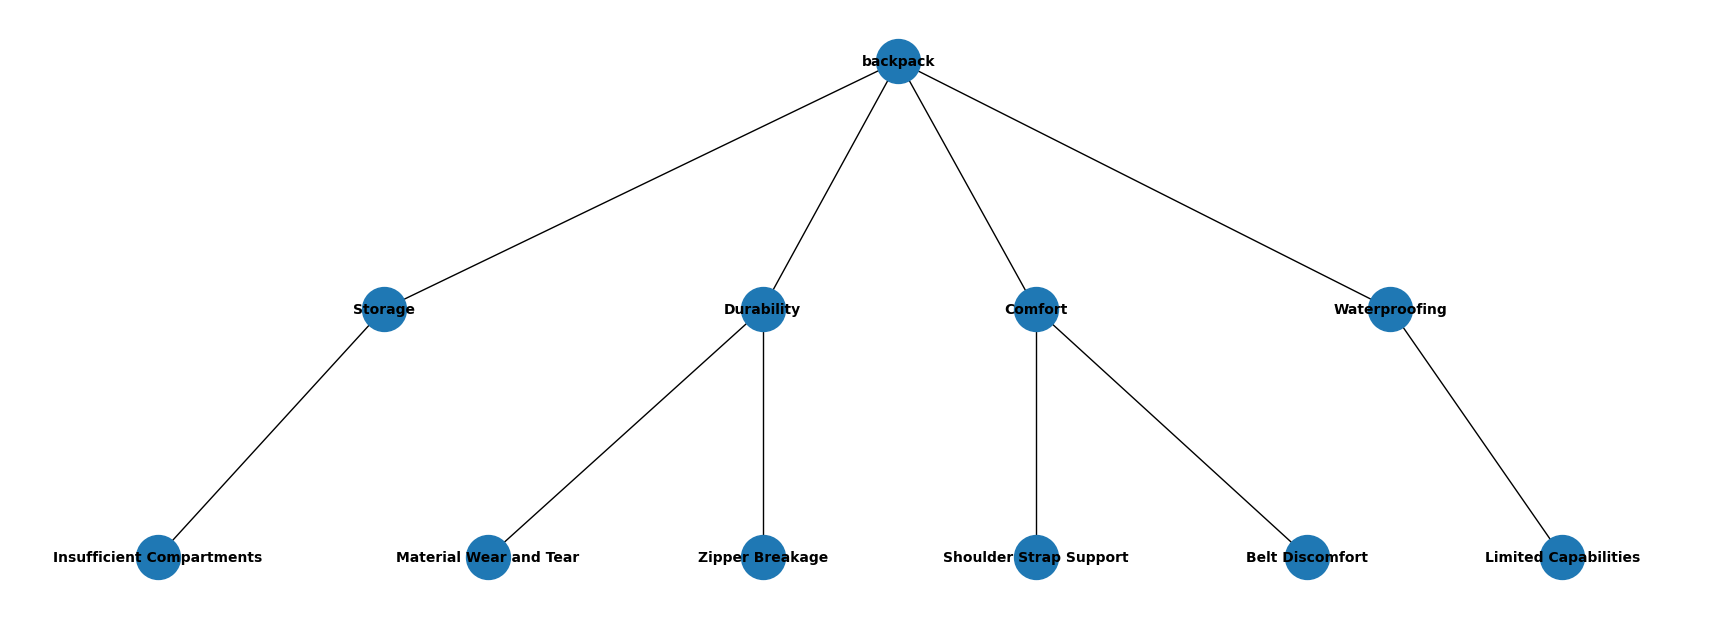

In [7]:
prob = """1. my backpack belt is hurting my sides when the backpack is heavy.
2. the zipers a braking after a year of use."""
top2.classify_exsisting_problems(prob)
top2.plot_hierarchy_problems()

raw result: Sure! Here is a list of the top 5 significant factors that influence lack of durability in the material used, leading to frequent wear and tear:

```python
factors = [
    {"factor": "Quality of Material", "description": "Low-quality materials tend to have less durability and are prone to wear and tear."},
    {"factor": "Environmental Conditions", "description": "Extreme temperatures, humidity, or exposure to chemicals can degrade the material and reduce its durability."},
    {"factor": "Improper Maintenance", "description": "Lack of proper cleaning, lubrication, or regular upkeep can accelerate wear and tear on the material."},
    {"factor": "Design Flaws", "description": "Inadequate design or poor engineering choices can result in weak points or stress concentrations, leading to faster deterioration."},
    {"factor": "Intended Use and Load", "description": "Materials may wear out quickly if they are subjected to heavy loads, excessive stress, or used beyond their inte

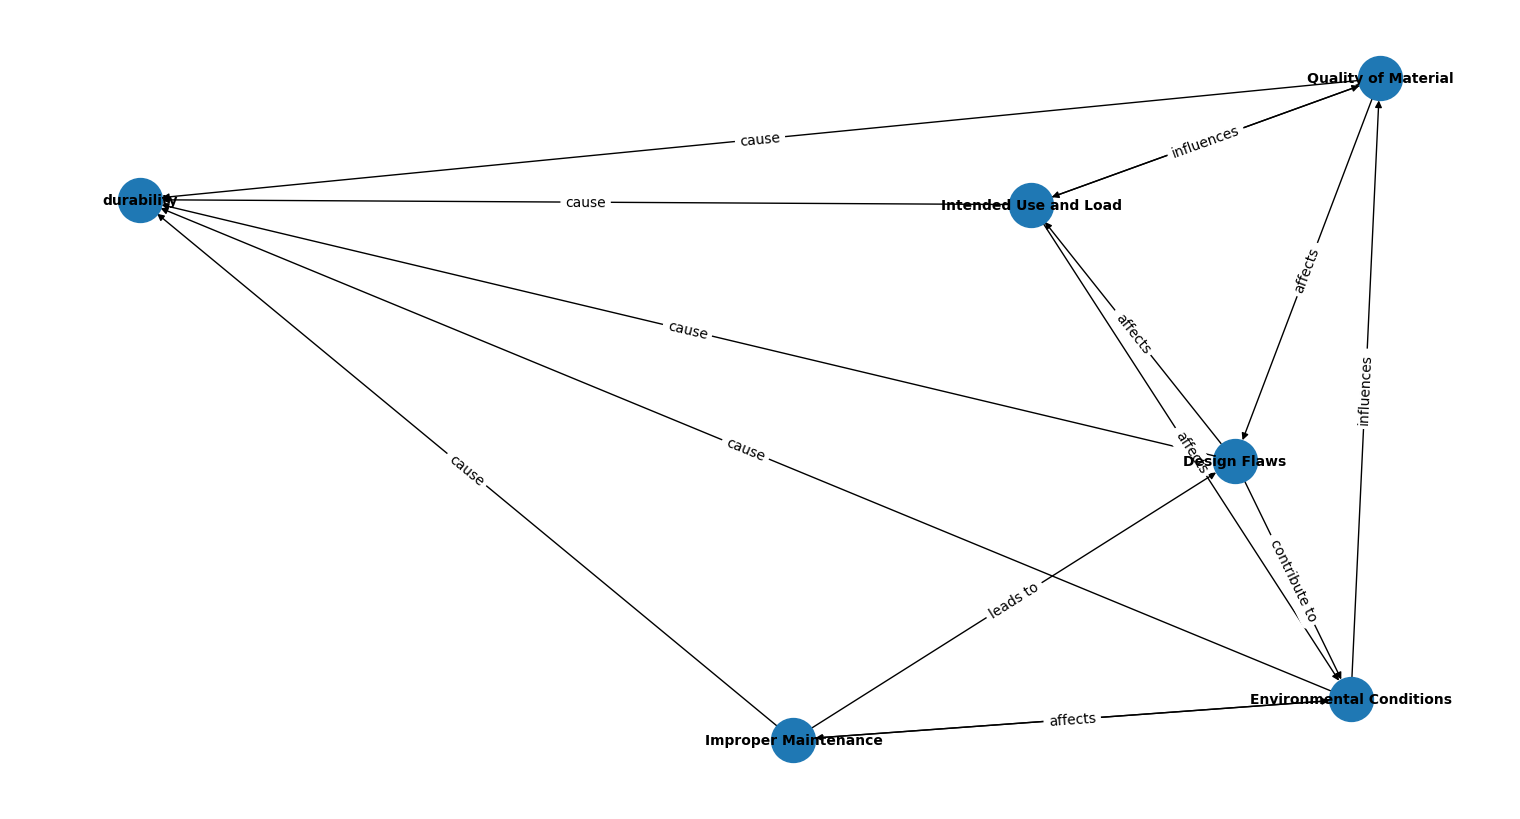

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600).


In [17]:
p = top2.problems[1]
p.create_factors()
p.build_knowledge_graph()

In [15]:
top2.challenges = []
top2.create_challenge(1)
print(top2.challenges[0].description)

Challenge: Enhancing Backpack Durability

Problem Explanation:
The current material used in backpack manufacturing lacks durability, resulting in frequent wear and tear. This issue leads to decreased product lifespan and customer dissatisfaction. To address this problem, the innovation team needs to find solutions that improve the durability of the backpacks.

Key Performance Indicators (KPIs):
1. Increase in Material Strength: Measure the improvement in the strength of the backpack material by conducting tests to determine its resistance to tearing, stretching, and abrasion. The goal is to enhance the material's durability, ensuring it can withstand regular use and external factors.

2. Reduction in Repair and Replacement Costs: Monitor the decrease in repair and replacement expenses associated with backpacks. By enhancing durability, the innovation team aims to reduce the frequency of repairs and replacements, resulting in cost savings for both the manufacturer and the customers.

KP

In [52]:
top2.challenges[0].solutions = []
top2.challenges[0].create_solutions(3)


{'main_class': 'Backpack Durability', 'sub_class': 'Material Improvement', 'description': 'Implementing a new material with higher strength and durability in backpack manufacturing.', 'grade': {'Cost': 4, 'Feasibility': 3, 'Efficiency': 4, 'Increase in Material Strength': 5, 'Reduction in Repair and Replacement Costs': 5}}
{'main_class': 'Backpack Durability', 'sub_class': 'Reinforcement', 'description': 'Reinforcing critical areas of the backpack with additional layers or patches to improve durability.', 'grade': {'Cost': 3, 'Feasibility': 5, 'Efficiency': 4, 'Increase in Material Strength': 4, 'Reduction in Repair and Replacement Costs': 4}}


Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised Timeout: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600).


{'main_class': 'Backpack Durability', 'sub_class': 'Maintenance and Inspection', 'description': 'Conducting regular maintenance and inspections on backpacks to identify and address potential issues before they become major problems.', 'grade': {'Cost': 5, 'Feasibility': 5, 'Efficiency': 3, 'Increase in Material Strength': 3, 'Reduction in Repair and Replacement Costs': 5}}


In [51]:
top2.challenges[0].create_fundamental_problems()
solutions = top2.challenges[0].get_solutions_str()
print(solutions)

Reinforced Material Technology:Incorporating advanced materials to enhance durability and resist tearing, stretching, and abrasion
fundamental problems:
1. Lack of durability: The materials currently used in the solution are not durable enough to withstand tearing, stretching, and abrasion.
2. Susceptibility to tearing: The current materials used in the solution are easily torn when subjected to stress or pressure.
3. Lack of resistance to stretching: The current materials used in the solution lose their shape and integrity when stretched, reducing their effectiveness.
4. Vulnerability to abrasion: The current materials used in the solution are prone to wear and damage when subjected to friction or rubbing against surfaces.

Improved Stitching and Reinforcements:Enhancing strength and durability through improved stitching techniques and reinforcements
Fundamental problems:
1. Weak stitching techniques: The current stitching techniques used in the manufacturing process are not strong en

again


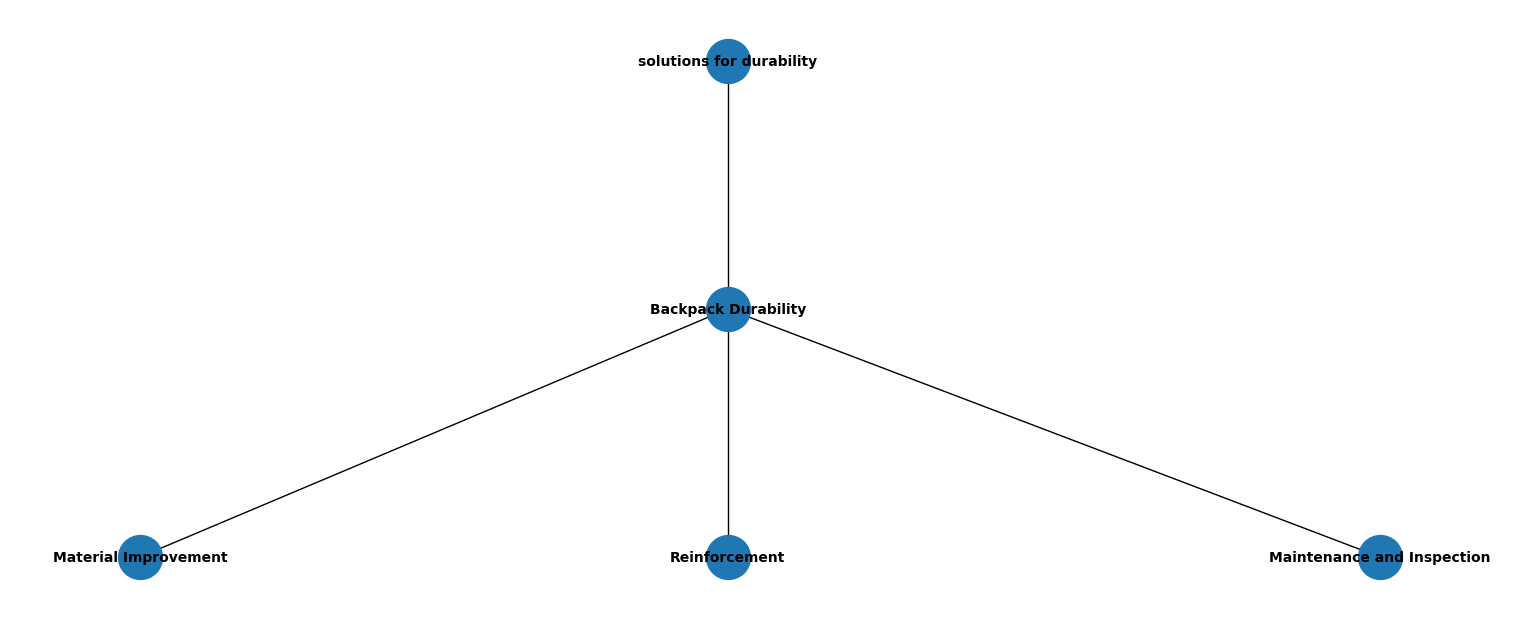

In [76]:
plt = top2.challenges[0].plot_hierarchy_solutions()

In [148]:
sol = top2.challenges[0].solutions[0]
print(sol.solution_str())
sol_update = """
give example for metirials we should use for the backpack, and what stiching we need to use that will make the backpack stronger.
our bags already go through a strict quality control process, so we can remove that part from the solution.
"""
sol.update_solution(sol_update)



    [solution class: Backpack Durability Enhancement 

    sub class: Reinforced Material and Stitching 

    solution description: To enhance the durability of the backpacks, one solution is to use reinforced material and stitching techniques. For example, we can use materials such as nylon or Cordura, which are known for their strength and resistance to wear and tear. Additionally, we can employ double or triple stitching methods, which provide extra reinforcement and prevent seams from unraveling. These measures will make the backpacks stronger and more durable. 

    grade: {'Cost': 3, 'Feasibility': 4, 'Efficiency': 4, 'Average Lifespan Increase': 5, 'Customer Complaints Decrease': 5}]
{
    "main_class": "Backpack Durability Enhancement",
    "sub_class": "Reinforced Material and Stitching",
    "description": "To enhance the durability of the backpacks, one solution is to use reinforced material and stitching techniques. For example, we can use materials such as nylon or Cordur

<module 'matplotlib.pyplot' from 'c:\\Users\\matan\\miniconda3\\envs\\myenv\\lib\\site-packages\\matplotlib\\pyplot.py'>


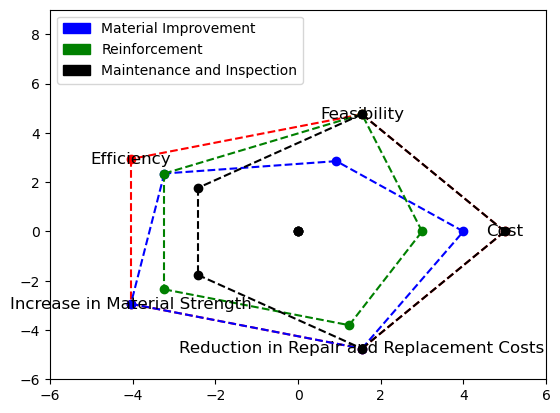

In [66]:
plt = top2.challenges[0].plot_solutions_polygons(to_show = False)
print(plt)

## Merge simillar problems

In [108]:
def merge_problems(problems_str):
    llm = ChatOpenAI(temperature = 0.5, model="gpt-3.5-turbo")
    template = """Given a list of problems {problems}, identify similar problems and put them in a list of simillar problems. 
    after that each list of similar problems should be merged into a single problem and put in a python list of merged problems."""

    prompt = PromptTemplate(input_variables={"problems"}, template=template)
    chain = LLMChain(llm=llm, prompt=prompt)
    result = chain.run(problems = problems_str)
    # print(result)
    just_prob = result[result.find("["):]
    problems = ast.literal_eval(just_prob)
    return problems

problems = """Problem: "The zipper on my backpack is stuck, and I can't open it."
    Problem: "I'm having trouble closing the zipper on my backpack; it's jammed."
    Problem: "The zipper of my backpack is difficult to zip, and it often gets stuck."
    Problem: "I accidentally spilled a drink inside my backpack, and my books are soaked."
    Problem: "I lost one of the shoulder straps on my backpack, and it's causing discomfort."""
merged_problems = merge_problems(problems)
print(merged_problems)

["The zipper on my backpack is stuck, and I'm having trouble opening or closing it. It's difficult to zip and often gets jammed.", 'I accidentally spilled a drink inside my backpack, and now my books are soaked.', "I lost one of the shoulder straps on my backpack, and it's causing discomfort."]


In [ ]:
def filter_problems(problems_str, topic):
    llm = ChatOpenAI(temperature = 0.5, model="gpt-3.5-turbo")


    template = """Given a list of problems {problems}, remove all problems that are not related to {topic} or problems that are not related to the product itself.
    """
    prompt = PromptTemplate(input_variables={"problems", "topic"}, template=template)
    chain = LLMChain(llm=llm, prompt=prompt)
    result = chain.run(problems = problems_str, topic = topic)
    # print(result)
    just_prob = result[result.find("["):]
    problems = ast.literal_eval(just_prob)
    return problems

problems = """Problem: "The zipper on my backpack is stuck, and I can't open it."
    Problem: "I'm having trouble closing the zipper on my backpack; it's jammed."
    Problem: "The zipper of my backpack is difficult to zip, and it often gets stuck."
    Problem: "I accidentally spilled a drink inside my backpack, and my books are soaked."
    Problem: "I lost one of the shoulder straps on my backpack, and it's causing discomfort."""
filtered_problems = filter_problems(problems, "backpack")
print(filtered_problems)

## Solution conversation

In [90]:
from langchain.chains.conversation.memory import ConversationSummaryMemory
from langchain import OpenAI
from langchain.chains import ConversationChain
chall = top2.challenges[0]

first_input = """the following is a conversetion between an AI and human, where the target of the conversation is to develop the best solutions for problems about the topic: {topic}.
            we created a challenge that explain the problem and how to evalute the solutions, the challenge is {challenge}.
            the solutions that we have so far are: {solutions}.""".format(topic=top2.name, challenge=chall.description, solutions=chall.get_solutions_str())

template = """
            pls help develop the solutions or develop new solution with the human.
            If the AI does not know the answer to a question, it truthfully says it does not know, and he does not hallucinate.
            conversation history:
            {history}
            
            Conversation:
            Human: {input}
            AI: """
prompt = PromptTemplate(input_variables=["history", "input"], template=template)
llm = OpenAI(model_name='gpt-3.5-turbo', temperature=0, max_tokens = 256)
summary_memory = ConversationSummaryMemory(llm=OpenAI())
conversation = ConversationChain(llm=llm, verbose=True, prompt=prompt, memory=summary_memory)
conversation.predict(input=first_input)

c:\Users\matan\miniconda3\envs\myenv\lib\site-packages\langchain\llms\openai.py:200: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(
c:\Users\matan\miniconda3\envs\myenv\lib\site-packages\langchain\llms\openai.py:787: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain.chat_models import ChatOpenAI`
  warnings.warn(




> Entering new ConversationChain chain...
Prompt after formatting:

            pls help develop the solutions or develop new solution with the human.
            If the AI does not know the answer to a question, it truthfully says it does not know, and he does not hallucinate.
            conversation history:
            
            
            Conversation:
            Human: the following is a conversetion between an AI and human, where the target of the conversation is to develop the best solutions for problems about the topic: backpack.
            we created a challenge that explain the problem and how to evalute the solutions, the challenge is Challenge: Enhancing Backpack Durability

Problem Explanation:
The current material used in backpack manufacturing lacks durability, resulting in frequent wear and tear. This issue leads to decreased product lifespan and customer dissatisfaction. To address this problem, the innovation team needs to find solutions that improve the dur

'Based on the problem explanation and the KPIs, it seems like the current solutions you have are on the right track. However, I can help you further develop these solutions or come up with new ones. Here are a few additional ideas:\n\n1. Design Optimization: Analyze the current backpack design and identify areas that are prone to wear and tear. Redesign these areas to distribute stress more evenly and reinforce them with stronger materials or additional stitching.\n\n2. Quality Control: Implement strict quality control measures during the manufacturing process to ensure that only backpacks meeting the desired durability standards are released to the market. This can involve conducting regular tests and inspections on the materials, components, and finished products.\n\n3. User Feedback and Testing: Gather feedback from customers who have experienced durability issues with the backpacks. Use this feedback to identify specific weaknesses and areas for improvement. Additionally, conduct f

In [92]:
conversation.predict(input="lets look into the solution of reinforcing critical areas of the backpack, what is the 3 most important areas to reinforce? and how can we reinforce them?")



> Entering new ConversationChain chain...
Prompt after formatting:

            pls help develop the solutions or develop new solution with the human.
            If the AI does not know the answer to a question, it truthfully says it does not know, and he does not hallucinate.
            conversation history:
            
The human and AI are discussing solutions for improving the durability of backpacks. The AI suggests solutions such as design optimization, quality control, user feedback and testing, collaboration with material suppliers, warranty and customer support, reinforcing critical areas of the backpacks with additional layers or patches, and regular maintenance and inspections to identify and address potential issues. The AI also summarized the problem and each solution in one sentence: the problem is the lack of durability in backpacks, and the solutions include design optimization, quality control, user feedback and testing, collaboration with material suppliers, warra

'The three most important areas to reinforce in a backpack are the shoulder straps, the bottom of the backpack, and the seams. To reinforce the shoulder straps, we can use stronger and more durable materials, such as reinforced nylon or webbing. Additionally, we can add extra stitching or double stitching to ensure the straps can withstand heavy loads. \n\nTo reinforce the bottom of the backpack, we can use a thicker and more durable material, such as reinforced PVC or rubber. Adding a layer of padding or foam can also help absorb impact and protect the contents of the backpack. Reinforcing the seams can be done by using stronger thread and double stitching, or even using heat-sealed seams for added durability.\n\nOverall, reinforcing these critical areas can greatly improve the durability and longevity of the backpack, ensuring it can withstand daily wear and tear, as well as heavy loads.'

In [93]:
conversation.predict(input="from the customers we got that the shoulder straps are damaged when its raining, how can we fix that?")



> Entering new ConversationChain chain...
Prompt after formatting:

            pls help develop the solutions or develop new solution with the human.
            If the AI does not know the answer to a question, it truthfully says it does not know, and he does not hallucinate.
            conversation history:
            
The human and AI are discussing solutions for improving the durability of backpacks. The AI suggests solutions such as design optimization, quality control, user feedback and testing, collaboration with material suppliers, warranty and customer support, reinforcing critical areas of the backpacks with additional layers or patches, and regular maintenance and inspections to identify and address potential issues. The AI also summarized the problem and each solution in one sentence: the problem is the lack of durability in backpacks, and the solutions include design optimization, quality control, user feedback and testing, collaboration with material suppliers, warra

"To address the issue of shoulder straps getting damaged when it's raining, we can consider a few potential solutions. One option is to use waterproof or water-resistant materials for the shoulder straps. This can help prevent water from seeping into the straps and causing damage. Another solution could be to add a protective cover or flap over the shoulder straps that can be easily deployed when it starts raining. This cover can provide an extra layer of protection and keep the straps dry. Additionally, reinforcing the shoulder straps with stronger and more durable materials, such as reinforced stitching or additional layers of padding, can help improve their durability and resistance to damage. It would also be beneficial to conduct user testing and gather feedback specifically on the shoulder straps to identify any design flaws or weaknesses that may contribute to their vulnerability in rainy conditions."

## Print all the data

backpack


    problem class: Storage
    sub class: Insufficient Compartments
    problem details: Insufficient storage compartments for organizing different items efficiently.


    problem class: material
    sub class: durability
    problem details: Lack of durability in the material used, leading to frequent wear and tear.


    problem class: Comfort
    sub class: Shoulder Strap Support
    problem details: Inadequate support and padding in the shoulder straps causing discomfort during extended use.


    problem class: mechanical
    sub class: waterproofing
    problem details: Limited waterproofing capabilities, making the backpack vulnerable to damage in rainy conditions.


    problem class: Comfort
    sub class: Belt Discomfort
    problem details: My backpack belt is hurting my sides when the backpack is heavy.


    problem class: mechanical
    sub class: zippers
    problem details: The zippers are breaking after a year of use.




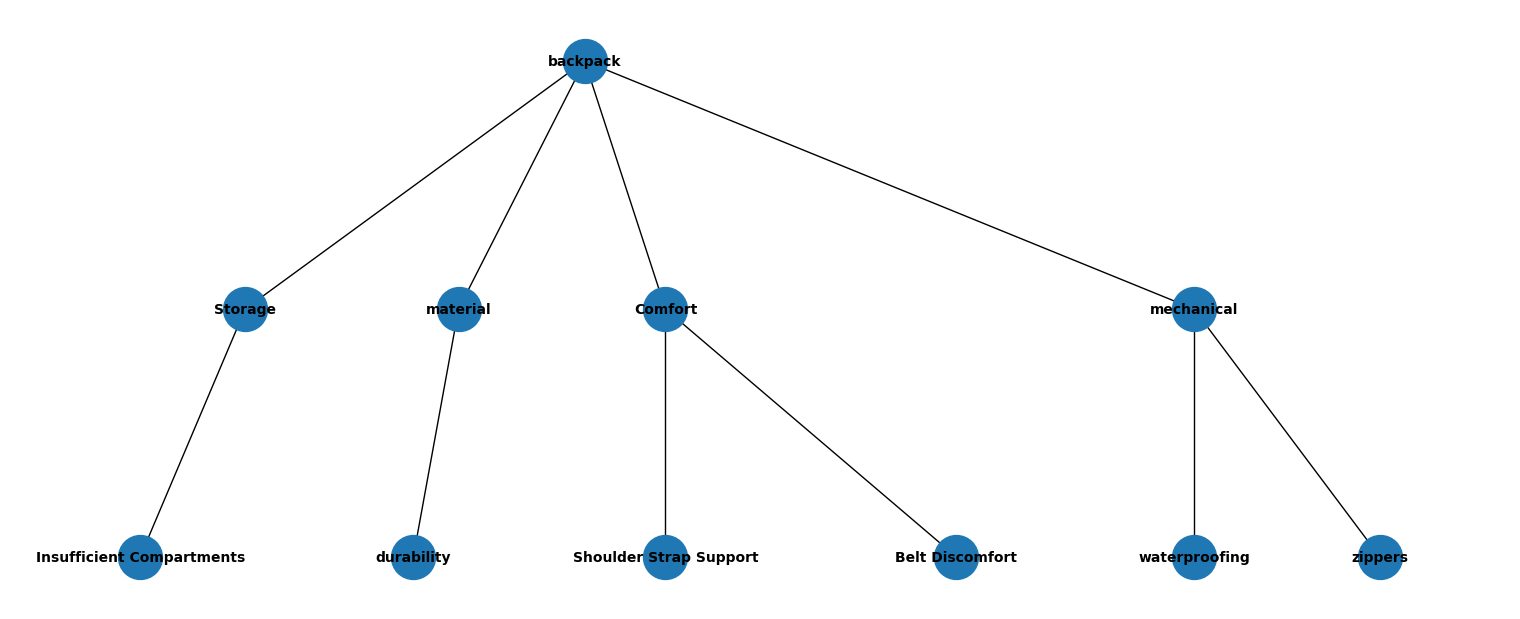


We look at 1 problem in particular and create from it a developed challenge. 
Challenge: Enhancing Backpack Durability

Problem Explanation:
The current material used in backpack manufacturing lacks durability, resulting in frequent wear and tear. This issue leads to decreased product lifespan and customer dissatisfaction. To address this problem, the innovation team needs to find solutions that improve the durability of the backpacks.

Key Performance Indicators (KPIs):
1. Increase in Material Strength: Measure the improvement in the strength of the backpack material by conducting tests to determine its resistance to tearing, stretching, and abrasion. The goal is to enhance the material's durability, ensuring it can withstand regular use and external factors.

2. Reduction in Repair and Replacement Costs: Monitor the decrease in repair and replacement expenses associated with backpacks. By enhancing durability, the innovation team aims to reduce the frequency of repairs and replaceme

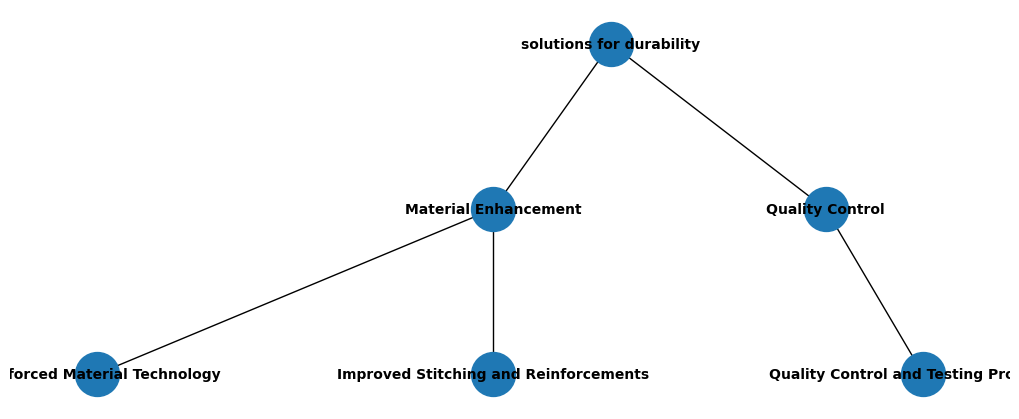

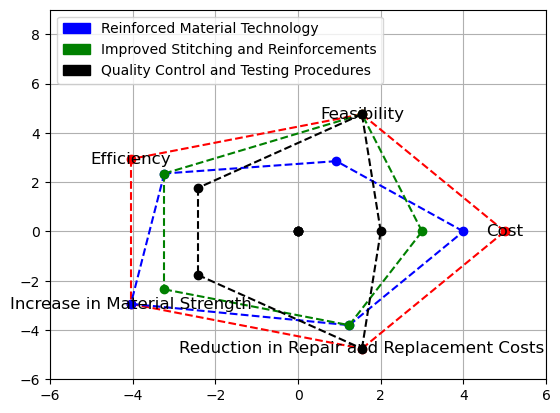

In [83]:
topic_info = ""
top = None
with open('data.pickle', 'rb') as file:
    top = pickle.load(file)
topic_info = top.name + "\n" + top.summary + "\n" + top.get_problems_str()
prob_tree_plot = top.plot_hierarchy_problems()
s1 = "\nWe look at 1 problem in particular and create from it a developed challenge. \n"
topic_challenges = s1 + top.get_challenges_str()
s2 = "\nFrom that challenge we create 3 optional solutions:\n"
sol_str = s2 + top.challenges[0].get_solutions_str()

print(topic_info)
prob_tree_plot.show()
print(topic_challenges + sol_str)
sol_tree_plot = top.challenges[0].plot_hierarchy_solutions((10,4))
sol_grades = top.challenges[0].plot_solutions_polygons(to_show = False)

In [49]:
def is_exsist(top, problem):
    llm = ChatOpenAI(temperature = 0.0, model="gpt-3.5-turbo")
    template = """given the classifictions: {problems_classes} and problems: {descriptions}, and a new problem: {problem}.
    if the new problem is already exist in the problem list return only the word "exist" without any introduction to your result. 
    else:
        find the best way to classify the new problem from the existing classofications.
        if none of the given classofication match perfectly to the new problem create new general class with meaningful name that will describe the new problem.
        
        """
    prompt = PromptTemplate(input_variables={"problems_classes", "descriptions", "problem"}, template=template)
    chain = LLMChain(llm=llm, prompt=prompt)
    result = chain.run(problems_classes = top.get_problems_classes(), descriptions = top.get_problems_descriptions() ,problem = problem)
    print(result)
    if result.find("is already exist") != -1:
        print("problem already exist")
        return
    
    dict_template = """the below text describes a problem and classification for that problem.
        output the problem and class in the format of python dictionary: ["class": "class_name", "short_name": "name1", "description": "description1"]
        the text: {input}"""
    llm2 = ChatOpenAI(temperature = 0, model="gpt-3.5-turbo")
    prompt2 = PromptTemplate(input_variables={"input"}, template=dict_template)
    chain2 = LLMChain(llm=llm2, prompt=prompt2)
    result = chain2.run(input = result)
    print(result)




problems = """The zippers on my travel backpack keep getting stuck, making it frustrating to access my belongings."

"After just a few trips, the stitching on my backpack is coming undone, and it's falling apart."

"The straps on my backpack are uncomfortable, and they dig into my shoulders during long walks."

"I thought my backpack was water-resistant, but my belongings got soaked in the rain on my last trip."

"The design of my travel backpack doesn't provide enough compartments or pockets, so it's challenging to stay organized."

"The handle on my rolling backpack broke, and now I have to carry it everywhere, defeating the purpose."

"The backpack's zippers are too flimsy, and I'm worried about the security of my items when traveling."

"My backpack's material is not durable; it got torn easily when I accidentally scraped it against a rough surface."

"The size of the backpack is misleading; it's smaller than it appears in the pictures, and I can't fit all my essentials."

"The backpack's weight distribution is uneven, and it strains my back when I carry it for extended periods."""
problems = problems.split("\n\n")

for prob in problems[3:5]:
    is_exsist(top2, prob)
# is_exsist(top2, problems[2])
# top2.add_problem(problems[2])

# for prob in problems[:2]:
#     top2.add_problem(prob)



The new problem "I thought my backpack was water-resistant, but my belongings got soaked in the rain on my last trip" does not exist in the existing problem list. Therefore, we need to classify it based on the existing classifications.

The new problem can be classified under the existing classification of "Limited waterproofing capabilities, making the backpack vulnerable to damage in rainy conditions." This classification aligns with the issue of the backpack not being as water-resistant as expected, resulting in belongings getting soaked in the rain.

Therefore, the new problem can be classified under the existing classification of "Waterproofing" or "Water-resistance."
{"class": "Waterproofing", "short_name": "Limited waterproofing capabilities", "description": "The backpack is not as water-resistant as expected, resulting in belongings getting soaked in the rain."}
The new problem "The design of my travel backpack doesn't provide enough compartments or pockets, so it's challenging

In [50]:
# Deserialize the topic storage
with open('data.pickle', 'rb') as file:
    top = pickle.load(file)

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [01/Nov/2023 16:02:13] "GET / HTTP/1.1" 200 -


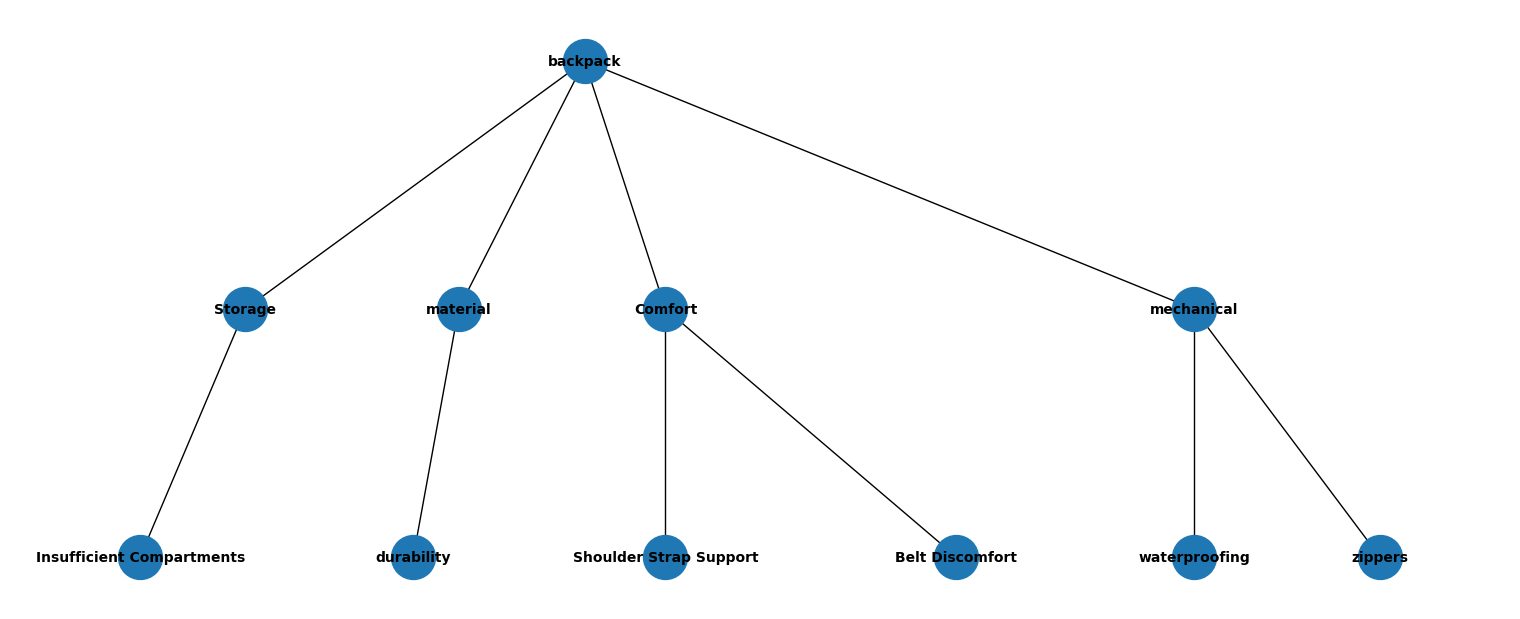

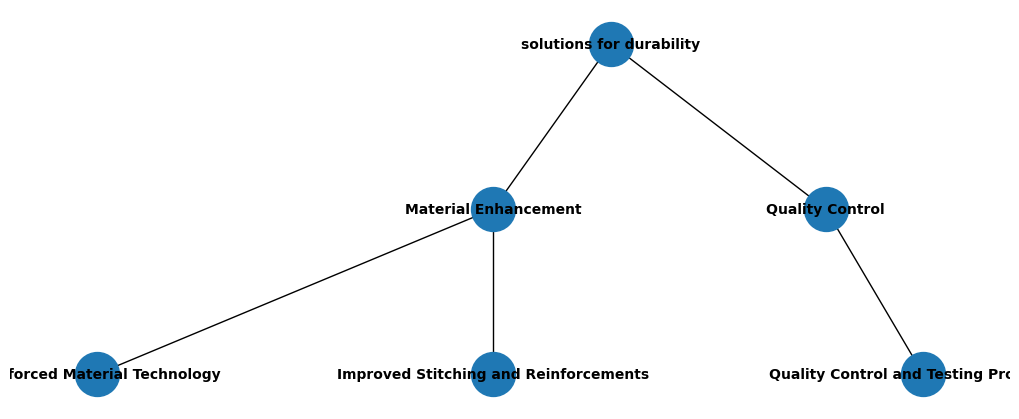

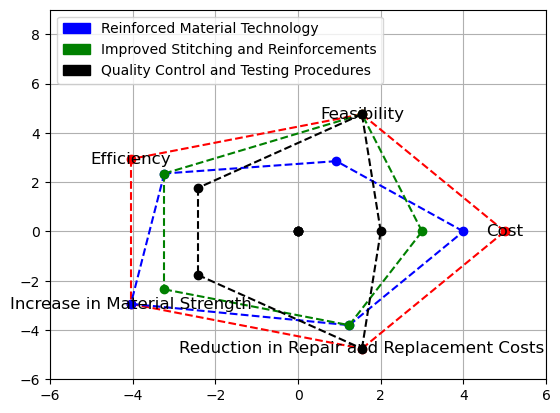

In [86]:
from utils import *

from flask import Flask, render_template
import pickle
import matplotlib.pyplot as plt
import io
import base64

app = Flask(__name__)

@app.route('/')
def display_content():
    # Load data from your 'data.pickle' file
    topic_info, prob_str, prob_tree_plot, topic_challenges, sol_str, sol_tree_plot, sol_grades = load_data()

    return render_template('index.html',
                           topic_info=topic_info,
                           prob_str=prob_str,
                           prob_tree_plot=prob_tree_plot,
                           topic_challenges=topic_challenges,
                           sol_str=sol_str,
                           sol_tree_plot=sol_tree_plot,
                           sol_grades=sol_grades)

def load_data():
    # Load data from your 'data.pickle' file
    topic_info = ""
    prob_tree_plot = None
    topic_challenges = ""
    sol_tree_plot = None
    sol_grades = None

    with open('data.pickle', 'rb') as file:
        top = pickle.load(file)
        topic_info = "Topic is " + top.name + "\n"
        prob_str = top.get_problems_str()
        prob_tree_plot = plot_to_base64(top.plot_hierarchy_problems())
        s1 = "\nWe look at 1 problem in particular and create from it a developed challenge. \n"
        topic_challenges = s1 + top.get_challenges_str()
        s2 = "\nFrom that challenge, we create 3 optional solutions:\n"
        sol_str = s2 + top.challenges[0].get_solutions_str()

        sol_tree_plot = plot_to_base64(top.challenges[0].plot_hierarchy_solutions((10, 4)))
        sol_grades = plot_to_base64(top.challenges[0].plot_solutions_polygons(to_show=False))

    return topic_info, prob_str, prob_tree_plot, topic_challenges, sol_str, sol_tree_plot, sol_grades

def plot_to_base64(plt_obj):
    buffer = io.BytesIO()
    plt_obj.savefig(buffer, format='png')
    buffer.seek(0)
    plot_data = base64.b64encode(buffer.read()).decode()
    return plot_data

if __name__ == '__main__':
    app.run()


In [35]:
with open('data.pickle', 'wb') as file:
    pickle.dump(top2, file)